# From Softmax to ArcFace: Building Better Embeddings with Additive Angular Margins

This notebook contains the code accompanying the blog post [From Softmax to ArcFace: Building Better Embeddings with Additive Angular Margins](https://example.com). It demonstrates the implementation of various models, loss functions, and metrics, including:

- Standard Softmax, normalized Softmax, and ArcFace models
- ArcFace Additive Margin Loss
- Cluster quality evaluation using the Dunn Index
- Visualization of embeddings and decision boundaries

For a detailed explanation of the concepts and methods, please refer to the blog post.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.optim as optim
from torchvision import datasets, transforms

import copy
import math
import numpy as np
from pathlib import Path
from sklearn.metrics import pairwise_distances
from sklearn.datasets import make_blobs

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
!nvidia-smi

Thu Aug 14 02:04:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.144                Driver Version: 570.144        CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5090        Off |   00000000:07:00.0 Off |                  N/A |
|  0%   43C    P8             11W /  575W |     154MiB /  32607MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Print library versions
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.7.1+cu128
CUDA version: 12.8


In [4]:
DATA_DIR = Path("./data")
STANDARD_SOFTMAX_MODEL = DATA_DIR / "mnist_standard_softmax_model.pth"
SOFTMAX_NO_CLASSIFIER_BIAS_MODEL = (
    DATA_DIR / "mnist_softmax_no_classifier_bias_model.pth"
)
SOFTMAX_NORMALIZED_MODEL = DATA_DIR / "mnist_softmax_normalized_model.pth"
ARCFACE_MODEL = DATA_DIR / "mnist_arcface_model.pth"

## Dataset

In [5]:
# Data loading
num_classes = 5

def load_datasets(num_classes=num_classes):
    """
    Load and preprocess the MNIST dataset, filtering to include only the first
    `num_classes` digits.

    Args:
        num_classes (int): Number of classes to include (default: 5).

    Returns:
        tuple: (train_dataset, test_dataset) - Filtered training and
          testing datasets.
    """
    # Define preprocessing transforms
    transform = transforms.Compose(
        [
            transforms.ToTensor(),  # Convert images to tensors (0-1 range)
            transforms.Normalize(
                (0.1307,), (0.3081,)
            ),  # Normalize using MNIST mean and std
        ]
    )

    # Load MNIST training data
    train_dataset = datasets.MNIST(
        root="./data", train=True, download=True, transform=transform
    )
    # Load MNIST test data
    test_dataset = datasets.MNIST(
        root="./data", train=False, download=True, transform=transform
    )

    # Filter training data to keep only the first num_classes
    train_mask = train_dataset.targets < num_classes
    train_dataset.data = train_dataset.data[train_mask]
    train_dataset.targets = train_dataset.targets[train_mask]

    # Filter test data to keep only the first num_classes
    test_mask = test_dataset.targets < num_classes
    test_dataset.data = test_dataset.data[test_mask]
    test_dataset.targets = test_dataset.targets[test_mask]

    return train_dataset, test_dataset

In [6]:
train_dataset, test_dataset = load_datasets()

100%|██████████| 9.91M/9.91M [00:00<00:00, 14.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 421kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.78MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.65MB/s]


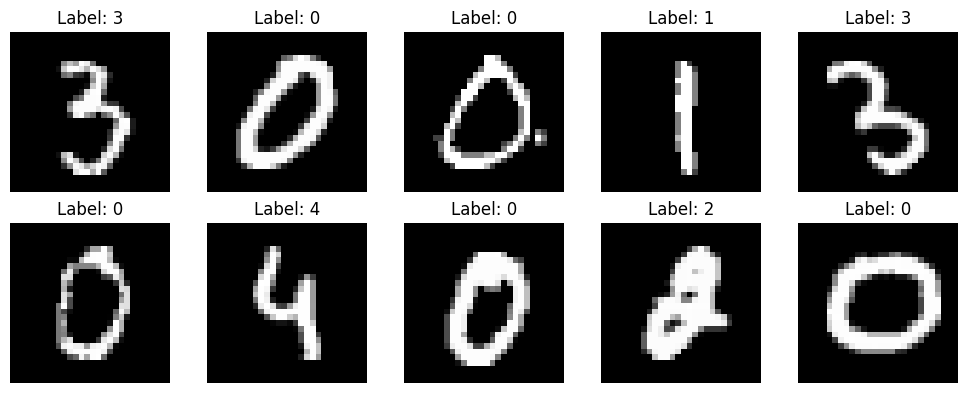

In [7]:
# Show example images from the dataset
def show_example_images(dataset):
    """
    Display a grid of 10 random example images from the given dataset.

    Args:
        dataset (Dataset): The dataset containing images and labels.
    """
    # Get number of samples in the dataset
    num_samples = len(dataset)

    # Get 10 random indices
    indices = np.random.choice(num_samples, size=10, replace=False)
    
    # Plot the first 10 images in a grid
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, dataset_idx in enumerate(indices):
        ax = axes[i // 5, i % 5]
        ax.imshow(dataset[dataset_idx][0].squeeze(), cmap="gray")
        ax.set_title(f"Label: {dataset[dataset_idx][1]}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

show_example_images(train_dataset)

In [8]:
def load_data_loaders(num_classes=num_classes):
    """
    Load and preprocess MNIST dataset, using only the first num_classes digits.

    This function:
    1. Downloads MNIST if not already present
    2. Applies normalization using MNIST mean and std
    3. Filters to keep only the first num_classes digits (0-4)
    4. Creates data loaders for training and testing

    Returns:
        tuple: (train_loader, test_loader) - PyTorch DataLoader objects
    """
    train_dataset, test_dataset = load_datasets(num_classes)

    # Create data loaders with batching and shuffling
    loader_kwargs = dict(
        num_workers=4,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=2,
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=128, shuffle=True, **loader_kwargs
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=1000, shuffle=False, **loader_kwargs
    )

    return train_loader, test_loader

## Models and Loss

In [9]:
class EmbeddingNetwork(nn.Module):
    """
    Convolutional neural network for extracting embeddings from MNIST digits.

    This network transforms input images into embedding vectors of the 
    specified dimension. It consists of two convolutional layers with 
    BatchNorm followed by two fully connected layers.

    Args:
        embedding_dim (int): Dimension of the output embedding vectors
        normalize_embeddings (bool): Whether to L2-normalize the output 
          embeddings
    """

    def __init__(self, embedding_dim, normalize_embeddings=False):
        super().__init__()
        # First convolutional layer: 1 input channel (grayscale) -> 32 output
        # channels
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)  # BatchNorm after first conv
        self.pool = nn.MaxPool2d(2, 2)  # Reduces spatial dimensions by half

        # Second convolutional layer: 32 input channels -> 64 output channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)  # BatchNorm after second conv

        # First fully connected layer: flattened conv output -> 128 hidden
        # units
        self.fc1 = nn.Linear(64 * 7 * 7, 128, bias=False)
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity="relu")
        self.bn3 = nn.BatchNorm1d(128)  # BatchNorm after first FC layer

        # Second fully connected layer: 128 hidden units -> embedding_dim
        self.fc2 = nn.Linear(128, embedding_dim)
        nn.init.xavier_uniform_(self.fc2.weight)
        if self.fc2.bias is not None:
            nn.init.constant_(self.fc2.bias, 0.0)
        self.normalize_embeddings = normalize_embeddings
        self.relu = nn.ReLU()

    def forward(self, x):
        # First convolutional block with BatchNorm
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Second convolutional block with BatchNorm
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)

        # Flatten the spatial dimensions
        x = x.view(-1, 64 * 7 * 7)

        # First fully connected layer with BatchNorm
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.relu(x)

        # Output embedding layer
        # Note: we do not pass the embeddings through relu here as that would
        # limit the range of the embeddings and we want to allow negative
        # values for the embeddings.
        embedding = self.fc2(x)

        # Optionally normalize the embeddings to unit length
        if self.normalize_embeddings:
            embedding = F.normalize(embedding, dim=1)

        return embedding

In [10]:
class LinearClassifier(nn.Module):
    """
    Simple linear classifier that maps embeddings to class logits.

    This is a standard fully-connected layer that projects input 
    embeddings to class logits for classification.

    Args:
        embedding_dim (int): Dimension of the input embedding vectors.
        num_classes (int): Number of output classes.
        bias (bool): Whether to include a bias term in the classifier 
          (default: True).
    """

    def __init__(self, embedding_dim, num_classes, bias=True):
        super().__init__()
        self.fc = nn.Linear(embedding_dim, num_classes, bias=bias)
        nn.init.xavier_uniform_(self.fc.weight)
        if self.fc.bias is not None:
            nn.init.constant_(self.fc.bias, 0.0)

    def forward(self, x):
        # Project embeddings to class logits
        logits = self.fc(x)
        return logits

In [11]:
class CosineClassifier(nn.Linear):
    """
    Cosine similarity-based classifier for normalized embeddings.

    This classifier computes the cosine similarity between input
    embeddings and weight vectors for each class. It normalizes the
    weight vectors to ensure proper cosine similarity computation.

    Commonly used with ArcFace and other margin-based losses
    that operate on angular distances.

    Args:
        embed_dim (int): Dimension of input embeddings.
        num_classes (int): Number of output classes.
        bias (bool): Whether to include a bias term (default: False).
    """

    def __init__(self, embed_dim, num_classes, bias=False):
        super().__init__(embed_dim, num_classes, bias=bias)

    def reset_parameters(self):
        super().reset_parameters()
        # Initialize weights using Xavier uniform initialization
        nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            nn.init.constant_(self.bias, 0.0)

    def forward(self, z):
        # Compute cosine similarity by using normalized weight vectors
        x = F.linear(z, F.normalize(self.weight, dim=1), self.bias)
        return x

In [12]:
class MarginScheduler:
    """
    Scheduler for dynamically adjusting the margin parameter in margin-based
    losses.

    This scheduler gradually increases the margin from a starting value
    to a final value over a specified number of warm-up epochs. This
    helps stabilize training by starting with an easier task and
    gradually increasing the difficulty.

    Args:
        loss_fn (nn.Module): Loss function that has an 
          update_hyperparameters method accepting a margin parameter 'm'
        m_start (float): Initial margin value
        m_end (float): Final margin value
        warm_up_epochs (int): Number of epochs over which to linearly 
          increase the margin
        start_epoch (int): First epoch at which to start increasing the
          margin (default: 1)
    """

    def __init__(self, loss_fn, m_start, m_end, warm_up_epochs, start_epoch=1):
        self.loss_fn = loss_fn
        self.m_start = m_start
        self.m_end = m_end
        self.warm_up_epochs = warm_up_epochs
        self.start_epoch = start_epoch

    def step(self, epoch):
        """
        Compute the current margin based on the epoch and update the loss
        function.

        The margin is linearly interpolated from m_start to m_end
        over the warm-up period.

        Args:
            epoch (int): Current training epoch

        Returns:
            float: Current margin value
        """
        epoch = max(epoch - self.start_epoch, 0)
        frac = min(epoch / self.warm_up_epochs, 1.0)
        m = self.m_start + (self.m_end - self.m_start) * frac
        self.loss_fn.update_hyperparameters(m=m)
        return m

In [13]:
class ConfigurableModel(nn.Module):
    """
    Complete model combining embedding network with standard softmax
    classifier.

    This model uses a standard linear classifier on top of the embedding
    network and is trained with regular cross-entropy loss.

    Args:
        embedding_dim (int): Dimension of the embedding space 
          (default: 2)
    """

    def __init__(
        self,
        embedding_dim=2,
        embedding_normalized=False,
        classifier_bias=True,
        use_cosine_classifier=False,
    ):
        super().__init__()

        # Save configuration
        cfg = locals().copy()
        cfg.pop("self", None)
        # Remove all __NAME__ keys
        cfg = {
            k: v 
            for k, v in cfg.items() 
            if not k.startswith("__") and not k.endswith("__")
        }
        # Store configuration
        self._config = cfg

        # Feature extraction network
        self.embedding_net = EmbeddingNetwork(
            embedding_dim, normalize_embeddings=embedding_normalized
        )
        # Classification head
        if use_cosine_classifier:
            self.classifier = CosineClassifier(
                embedding_dim, num_classes, bias=classifier_bias
            )
        else:
            self.classifier = LinearClassifier(
                embedding_dim, num_classes, bias=classifier_bias
            )

    @classmethod
    def from_checkpoint(cls, path, map_location=None):
        ckpt = torch.load(path, map_location=map_location)
        model = cls(**ckpt["config"])
        model.load_state_dict(ckpt["state_dict"])
        return model

    def save_checkpoint(self, path):
        """
        Save the model checkpoint to the specified path.

        Args:
            path (str or Path): Path to save the checkpoint file
        """
        checkpoint = self.checkpoint_dict()
        torch.save(checkpoint, path)

    def checkpoint_dict(self):
        return {
            "config": self._config,
            "state_dict": self.state_dict(),
        }

    def forward(self, x):
        # Extract embeddings from input images
        embedding = self.embedding_net(x)
        # Classify embeddings into logits
        logits = self.classifier(embedding)
        # Return both logits and embeddings for training/visualization
        return logits, embedding

In [14]:
class ArcFaceLoss(nn.Module):
    """
    ArcFace margin-based loss function for improving embedding discrimination.

    ArcFace adds an angular margin penalty to the target logit, which
    encourages the model to create more discriminative embeddings with
    larger inter-class separation and intra-class compactness.

    Args:
        s (float): Scale factor for logits (default: 30.0)
        m (float): Angular margin in radians (default: 1.0)
    """

    def __init__(self, s=30.0, m=1.0):
        super().__init__()
        self.update_hyperparameters(m=m, s=s)

    def update_hyperparameters(self, s=None, m=None):
        """
        Update the scale and margin hyperparameters.

        Args:
            s (float): New scale factor (optional)
            m (float): New angular margin in radians (optional)
        """
        if s is not None:
            self.s = s
        if m is not None:
            self.m = m
            # Recompute trigonometric values for the new margin
            self.cos_m = math.cos(m)
            self.sin_m = math.sin(m)

    def forward(self, cos_theta, labels):
        # Clamp cosine values to avoid numerical instability
        cos_theta = torch.clamp(cos_theta, -1.0 + 1e-7, 1.0 - 1e-7)

        # Compute sine values using the Pythagorean identity:
        #
        #   sin²(θ) + cos²(θ) = 1
        #   sin(θ) = √(1 - cos²(θ))
        #
        sin_theta = torch.sqrt(1.0 - torch.pow(cos_theta, 2))

        # Apply the angular margin penalty: cos(θ+m)
        # Using the trigonometric addition formula:
        #
        #   cos(θ+m) = cos(θ)cos(m) - sin(θ)sin(m)
        #
        phi = cos_theta * self.cos_m - sin_theta * self.sin_m

        # Create one-hot encoding of labels
        one_hot = (
            F.one_hot(labels, num_classes=cos_theta.size(1))
            .float()
            .to(cos_theta.device)
        )

        # Apply margin penalty only to the target class logits
        logits = cos_theta * (1 - one_hot) + phi * one_hot

        # Apply scaling and compute cross-entropy loss
        loss = F.cross_entropy(self.s * logits, labels)
        return loss

## Dunn Index

In [15]:
def get_centroids(embeddings, labels, metric="cosine"):
    """
    Calculate centroids for each cluster of embeddings.

    Args:
        embeddings (numpy.ndarray): Array of shape (N, D) containing N 
          embedding vectors of dimension D
        labels (numpy.ndarray): Array of shape (N,) containing 
          class/cluster labels
        metric (str): Distance metric used, affects whether centroids
          are normalized ('cosine' will normalize centroids)

    Returns:
        tuple: (centroids, centroid_labels)
            - centroids (numpy.ndarray): Array of shape (K, D)
                containing K cluster centroids
            - centroid_labels (numpy.ndarray): Array of shape (K,) with
                labels corresponding to centroids
    """
    # Determine the number of unique classes
    classes = np.unique(labels)

    # Sort classes to ensure consistent ordering
    classes.sort()

    # Calculate the centroid for each class
    centroids = []
    kept_classes = []
    for k in classes:
        # Get all embeddings belonging to this class
        cluster_points = embeddings[labels == k]

        # If no points in the cluster, skip to avoid empty mean calculation
        if len(cluster_points) == 0:
            continue

        # Calculate the centroid as the mean of the cluster points
        centroid = cluster_points.mean(axis=0)

        # Normalize the centroid if using cosine distance
        if metric == "cosine":
            centroid = centroid / np.linalg.norm(centroid)

        centroids.append(centroid)
        kept_classes.append(k)

    return np.vstack(centroids), np.array(kept_classes)

In [16]:
def distances_to_point_cosine(points, ref_point):
    """
    Calculate cosine distances from multiple points to a reference point.

    Args:
        points (numpy.ndarray): Array of shape (N, D) containing N
          points in D-dimensional space
        ref_point (numpy.ndarray): Reference point of shape (D,)

    Returns:
        numpy.ndarray: Array of shape (N,) containing cosine distances
    """
    p_norm = points / np.linalg.norm(points, axis=1, keepdims=True)
    ref_norm = ref_point / np.linalg.norm(ref_point)
    return 1 - np.dot(p_norm, ref_norm)


def distances_to_point_euclidean(points, ref_point):
    """
    Calculate Euclidean distances from multiple points to a reference point.

    Args:
        points (numpy.ndarray): Array of shape (N, D) containing N 
          points in D-dimensional space
        ref_point (numpy.ndarray): Reference point of shape (D,)

    Returns:
        numpy.ndarray: Array of shape (N,) containing Euclidean
          distances
    """
    return np.linalg.norm(points - ref_point, axis=1)


def distances_to_point(points, ref_point, metric="cosine"):
    """
    Calculate distances from multiple points to a reference point using
    specified metric.

    Args:
        points (numpy.ndarray): Array of shape (N, D) containing N
          points in D-dimensional space
        ref_point (numpy.ndarray): Reference point of shape (D,)
        metric (str): Distance metric to use, either 'cosine' or
          'euclidean'

    Returns:
        numpy.ndarray: Array of shape (N,) containing distances

    Raises:
        ValueError: If an unsupported distance metric is specified
    """
    if metric == "cosine":
        return distances_to_point_cosine(points, ref_point)
    elif metric == "euclidean":
        return distances_to_point_euclidean(points, ref_point)
    else:
        raise ValueError(f"Unsupported distance metric: {metric}")

In [17]:
def filter_outliers_mask(points, labels, p=95, metric="cosine"):
    """
    Create a boolean mask identifying non-outlier points within each cluster.

    This function:
    1. Computes the centroid of each cluster
    2. Calculates distances from each point to its cluster centroid
    3. Identifies points within the p-th percentile of distances as inliers

    Args:
        points (numpy.ndarray): Array of shape (N, D) with N points in
          D-dimensional space
        labels (numpy.ndarray): Array of shape (N,) containing cluster
          labels for each point
        p (int): Percentile threshold for outlier detection 
          (default: 95)
        metric (str): Distance metric to use ('cosine' or 'euclidean')

    Returns:
        numpy.ndarray: Boolean mask of shape (N,) where True indicates
          inlier points
    """
    # Create mask for valid points
    mask = np.zeros(len(points), dtype=bool)

    # Find the centroids of each cluster
    centroids, centroid_labels = get_centroids(points, labels, metric=metric)

    # Filter out point outliers by using p95 of centroid distances
    for centroid, label in zip(centroids, centroid_labels):
        indicies = np.where(labels == label)[0]
        cluster_points = points[indicies]

        # Skip empty clusters
        if len(cluster_points) == 0:
            continue

        # Calculate distance from centroid for all points in cluster
        dists = distances_to_point(cluster_points, centroid, metric=metric)

        # Calculate the p percentile distance
        threshold = np.percentile(dists, p)

        # Keep points within threshold distance
        inlier_local = dists <= threshold
        mask[indicies[inlier_local]] = True

    return mask

In [18]:
def find_min_pairwise_distance(points, metric="cosine"):
    """
    Find the minimum pairwise distance between any two points in a set.

    This function:
    1. Computes a distance matrix between all pairs of points
    2. Extracts the upper triangular part of the matrix (excluding
      self-distances)
    3. Returns the minimum of these distances

    Args:
        points (numpy.ndarray): Array of shape (N, D) where N is number
          of points and D is dimension
        metric (str): Distance metric to use ('cosine' or 'euclidean')

    Returns:
        float: Minimum distance between any two distinct points
    """
    # Calculate inter-cluster distances (minimum distance between cluster centroids)
    # This represents the separation between clusters
    distances = pairwise_distances(points, metric=metric)

    # Extract the upper triangular part of the distance matrix (excluding the diagonal)
    # to get all unique centroid-to-centroid distances
    i, j = np.triu_indices_from(distances, k=1)
    min_distance = distances[i, j].min()
    return min_distance

In [19]:
def dunn_index(points, labels, metric="cosine"):
    """
    Calculate the Dunn Index, a measure of cluster quality.

    The Dunn Index is defined as the ratio of the minimum inter-cluster
    distance to the maximum intra-cluster distance. Higher values
    indicate better clustering with compact, well-separated clusters.

    This implementation:
    1. Filters outliers to improve robustness
    2. Computes centroids for each cluster
    3. Calculates maximum diameter (intra-cluster distance) across all
      clusters
    4. Finds minimum distance between cluster centroids (inter-cluster
      distance)
    5. Returns their ratio

    Args:
        points (numpy.ndarray): Array of shape (N, D) containing N
          points in D-dimensional space
        labels (numpy.ndarray): Array of shape (N,) containing cluster
          labels for each point
        metric (str): Distance metric to use ('cosine' or 'euclidean')

    Returns:
        float: Dunn Index value (higher is better)
    """
    # Drop outliers
    mask = filter_outliers_mask(points, labels, metric=metric)
    points = points[mask]
    labels = labels[mask]

    # Find cluster centroids
    centroids, centroid_labels = get_centroids(points, labels, metric=metric)

    # Calculate intra-cluster distances (maximum distance within each cluster)
    # This represents the "diameter" of each cluster
    intra_distances = []
    for label in centroid_labels:
        cluster_points = points[labels == label]
        if len(cluster_points) <= 1:
            # Clusters with 0 or 1 point have 0 intra-distance
            intra_distances.append(0.0)
        else:
            # Calculate pairwise distances between all points in the cluster
            # Using vectorized operations for efficiency
            dists = pairwise_distances(cluster_points, metric=metric)

            # Maximum distance is the cluster diameter
            intra_distances.append(dists.max())

    # Find the maximum diameter across all clusters
    max_diameter = max(intra_distances)

    # Calculate inter-cluster distances (minimum distance between cluster centroids)
    # This represents the separation between clusters
    min_centroid_dist = find_min_pairwise_distance(centroids, metric=metric)

    return min_centroid_dist / max_diameter

In [20]:
# Cluster A: points at x=-1 and x=1  → diameter = 2
# Cluster B: points at x= 9 and x=11 → diameter = 2
# Separation between centroids at x=0 and x=10 → 10
#
# So Dunn = 10 / 2 = 5

cluster_a = np.array([[-1.0, 0.0], [1.0, 0.0]])
cluster_b = np.array([[9.0, 0.0], [11.0, 0.0]])
points = np.vstack([cluster_a, cluster_b])
labels = np.array([0, 0, 1, 1])

d = dunn_index(points, labels, metric="euclidean")
print("Two-cluster Dunn:", d)
assert abs(d - 5.0) < 1e-6, f"Expected 5.0, got {d}"

Two-cluster Dunn: 5.0


In [21]:
# We know that if blobs are far apart relative to their spread,
# the Dunn‐index should be quite > 1.

pts, labs = make_blobs(
    n_samples=300,
    centers=[[0, 0], [20, 0], [0, 20]],
    cluster_std=1.0,
    random_state=42,
)

d = dunn_index(pts, labs, metric="euclidean")
print("Three‐blob Dunn:", d)
assert d > 4.0, "Expected a fairly large Dunn (>4) for well-separated blobs"

Three‐blob Dunn: 4.440758808928687


In [22]:
pts2, labs2 = make_blobs(
    n_samples=300,
    centers=[[0, 0], [2, 0], [0, 2]],  # very close centers
    cluster_std=1.5,  # large spread
    random_state=42,
)

d2 = dunn_index(pts2, labs2, metric="euclidean")
print("Overlapping‐blob Dunn:", d2)
assert d2 < 1.0, "Expected Dunn <1 for overlapping clusters"

Overlapping‐blob Dunn: 0.271135771751076


## Model Training and Selection Functions

In [23]:
@torch.no_grad()
def print_train_test_accuracy(model, train_loader, test_loader):
    """
    Evaluate and print the accuracy of a model on training and test datasets.

    This function:
    1. Temporarily sets the model to evaluation mode
    2. Computes prediction accuracy on the training dataset
    3. Computes prediction accuracy on the test dataset
    4. Prints the results
    5. Restores the model's original training/evaluation state

    Args:
        model (nn.Module): Neural network model to evaluate
        train_loader (DataLoader): DataLoader for the training dataset
        test_loader (DataLoader): DataLoader for the test dataset

    Returns:
        tuple: (train_acc, test_acc) - Accuracy percentages for training
               and test sets
    """
    training = model.training
    model.eval()
    device = next(model.parameters()).device

    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            logits, _ = model(data)
            preds = logits.argmax(dim=1)
            total_correct += preds.eq(target).sum().item()
            total_samples += target.size(0)
    train_acc = 100.0 * total_correct / total_samples
    print(f"Train Accuracy: {train_acc:.2f}%")

    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            logits, _ = model(data)
            preds = logits.argmax(dim=1)
            total_correct += preds.eq(target).sum().item()
            total_samples += target.size(0)

    test_acc = 100.0 * total_correct / total_samples
    print(f"Test Accuracy: {test_acc:.2f}%")

    model.train(training)
    return train_acc, test_acc

In [24]:
def train_model(
    model,
    train_loader,
    test_loader,
    criterion,
    learning_rate=1e-5,
    margin_scheduler=None,
    min_epochs=25,
    patience=15,
):
    """
    Train a deep learning model with early stopping and learning rate
    scheduling.

    This function:
    1. Trains the model for a maximum number of epochs
    2. Applies gradient clipping to prevent exploding gradients
    3. Uses learning rate scheduling to adapt the learning rate
    4. Implements early stopping based on validation loss
    5. Tracks and saves the best model weights based on validation
      performance
    6. Supports margin scheduling for margin-based losses like ArcFace

    Args:
        model (nn.Module): Neural network model to train
        train_loader (DataLoader): DataLoader for the training dataset
        test_loader (DataLoader): DataLoader for the test dataset
        criterion (callable): Loss function
        learning_rate (float): Initial learning rate (default: 1e-5)
        margin_scheduler (MarginScheduler, optional): Scheduler for
          margin parameter
        min_epochs (int): Minimum number of epochs to train before early
          stopping (default: 25)
        patience (int): Number of epochs to wait for improvement before
          stopping (default: 15)

    Returns:
        nn.Module: Trained model with the best weights based on
          validation loss
    """
    # Set device (GPU if available, otherwise CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move model to the appropriate device if needed
    if next(model.parameters()).device != device:
        model.to(device)

    # Initialize optimizer with Adam and specified learning rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize learning rate scheduler that reduces LR when validation loss
    # plateaus
    # - mode='min': LR is reduced when the monitored quantity stops decreasing
    # - factor=0.1: multiply LR by 0.1 when triggered
    # - patience=3: wait for 3 epochs with no improvement before reducing LR
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.1, patience=5
    )

    # Training configuration parameters
    max_epochs = 200  # Maximum number of training epochs
    max_grad_norm = 1.0  # Maximum gradient norm for gradient clipping
    best_loss = float("inf")  # Initialize best validation loss with infinity
    best_weights = None  # Track best model weights
    counter = 0  # Counter for early stopping

    # Main training loop
    for epoch in range(1, max_epochs + 1):
        # Set model to training mode
        model.train()
        running_loss = 0.0
        epoch_grad_norms = []

        if margin_scheduler is not None:
            # Update margin hyperparameters if using ArcFace loss
            current_margin = margin_scheduler.step(epoch)

        # Iterate through mini-batches
        for batch_idx, (data, target) in enumerate(train_loader, 1):
            # Move data to the appropriate device
            data, target = data.to(device), target.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass: compute model outputs
            logits, _ = model(data)

            # Calculate loss
            loss = criterion(logits, target)

            # Backward pass: compute gradient of the loss with respect to model
            # parameters
            loss.backward()

            # Measure gradient norm before clipping (for monitoring purposes)
            total_norm = torch.nn.utils.clip_grad_norm_(
                model.parameters(), float("inf")
            )
            epoch_grad_norms.append(total_norm.item())

            # Apply gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            # Update weights
            optimizer.step()

            # Accumulate batch loss
            running_loss += loss.item()

        # Calculate average training loss for the epoch
        avg_train_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():  # Disable gradient calculation for validation
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                logits, _ = model(data)
                val_loss += criterion(logits, target).item()

        # Calculate average validation loss
        avg_val_loss = val_loss / len(test_loader)

        # Calculate average gradient norm for the epoch (for monitoring)
        avg_grad_norm = np.mean(epoch_grad_norms)

        # Print progress
        progress = {
            "Epoch": f"{epoch:>2}",
            "Train Loss": f"{avg_train_loss:.4f}",
            "Val Loss": f"{avg_val_loss:.4f}",
            "‖∇𝐿‖": f"{avg_grad_norm:.4f}",
            "α": f"{optimizer.param_groups[0]['lr']:.2e}",
        }

        if margin_scheduler is not None:
            progress["m"] = f"{current_margin:.2f}"

        progress_str = " | ".join(f"{k}: {v}" for k, v in progress.items())
        print(progress_str)

        # Update learning rate based on validation loss
        if epoch > min_epochs:
            scheduler.step(avg_val_loss)

        # Model checkpointing: save best model based on validation loss
        if epoch >= min_epochs:
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                best_weights = copy.deepcopy(model.state_dict())
                counter = 0  # Reset early stopping counter
            else:
                counter += 1
                # Early stopping if no improvement for 'patience' epochs
                if counter >= patience:
                    print(f"Early stopping at epoch {epoch}.")
                    break

    # Load the best model weights
    model.load_state_dict(best_weights)
    model.eval()  # Set model to evaluation mode for inference
    return model

In [25]:
@torch.no_grad()
def get_all_embeddings_and_labels(model, data_loader):
    """
    Extract embeddings and corresponding labels for all samples in a data
    loader.

    This function:
    1. Temporarily sets the model to evaluation mode
    2. Processes all batches in the data loader
    3. Extracts embeddings using the model's embedding network
    4. Collects labels from the data loader
    5. Restores the model's original training/evaluation state

    Args:
        model (nn.Module): Neural network model with an embedding_net
          component
        data_loader (DataLoader): PyTorch DataLoader containing input
          data and labels

    Returns:
        tuple: (embeddings, labels)
            - embeddings (numpy.ndarray): Array of shape (N, D)
                containing embeddings
            - labels (numpy.ndarray): Array of shape (N,) containing
                corresponding labels
    """
    training = model.training
    model.eval()
    device = next(model.parameters()).device
    all_embeddings = []
    all_labels = []
    for data, labels in data_loader:
        data = data.to(device)
        embeddings = model.embedding_net(data)
        all_embeddings.append(embeddings.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
    model.train(training)
    return np.concatenate(all_embeddings), np.concatenate(all_labels)

In [26]:
@torch.no_grad()
def dunn_index_for_model(model, data_loader, metric="cosine"):
    """
    Calculate the Dunn Index for a trained model using embeddings from a
    data loader.

    This function:
    1. Extracts embeddings and labels from the model using the provided
      data loader
    2. Computes the Dunn Index based on the embeddings and labels

    Args:
        model (nn.Module): Trained neural network model with an
          embedding_net component
        data_loader (DataLoader): PyTorch DataLoader containing input
          data and labels
        metric (str): Distance metric to use ('cosine' or 'euclidean')

    Returns:
        float: Dunn Index value (higher is better)
    """
    # Make sure the model is in evaluation mode
    training = model.training
    model.eval()

    # Extract embeddings and labels from the model
    embeddings, labels = get_all_embeddings_and_labels(model, data_loader)
    
    # Restore the model's original training state
    model.train(training)

    # Calculate and return the Dunn Index
    result = dunn_index(embeddings, labels, metric=metric)
    return result

In [27]:
def train_and_select_by_dunn_index(
    create_model_criterion_fn,
    train_loader,
    test_loader,
    learning_rate=1e-4,
    number_of_runs=5,
):
    """
    Train multiple instances of a model with different random initializations
    and select the one with the best Dunn index.

    The Dunn index measures the ratio of the minimum inter-cluster
    distance to the maximum intra-cluster distance, with higher values
    indicating better separation between clusters.

    This function:
    1. Trains multiple model instances with different random initializations
    2. Evaluates each trained model using the Dunn index
    3. Selects and returns the model with the highest Dunn index

    Args:
        create_model_criterion_fn (callable): Function that returns a
          fresh (model, criterion, additional_kwargs) tuple for each
          training run
        train_loader (DataLoader): DataLoader for the training dataset
        test_loader (DataLoader): DataLoader for the test dataset
        learning_rate (float): Learning rate for optimization
          (default: 1e-4)
        number_of_runs (int): Number of training runs with different
          initializations (default: 5)

    Returns:
        nn.Module: The trained model with the highest Dunn index
    """
    # Initialize tracking variables for the best model
    best_dunn_index = -1
    best_weights = None

    # Run the training process multiple times with different initializations
    for run_idx in range(number_of_runs):
        # Create a fresh model and criterion for each run
        # This ensures different random initializations for each training
        model, criterion, addl_kwargs = create_model_criterion_fn()

        # Display progress information
        print(f"Run {run_idx + 1}/{number_of_runs}")

        # Train the model using the train_model function
        # This returns the model with the best validation loss from this
        # specific run
        if "learning_rate" not in addl_kwargs:
            addl_kwargs["learning_rate"] = learning_rate
        model = train_model(
            model,
            train_loader,
            test_loader,
            criterion,
            **addl_kwargs,
        )

        # Calculate the Dunn index for this model's embeddings
        dunn_index_value = dunn_index_for_model(model, test_loader)
        print(f"Dunn Index: {dunn_index_value:.4f}")

        # Keep track of the model with the highest Dunn index
        if dunn_index_value > best_dunn_index:
            best_dunn_index = dunn_index_value
            best_weights = copy.deepcopy(model.state_dict())
            print(f"New best Dunn Index: {best_dunn_index:.4f}")

    # Load the weights from the model with the highest Dunn index
    model.load_state_dict(best_weights)
    print(f"Best Dunn Index: {best_dunn_index:.4f}")
    return model

In [28]:
def maybe_train_model(create_model_fn, model_path, learning_rate=1e-4):
    """
    Either load a pre-trained model if it exists or train a new model and save
    it.

    This function:
    1. Checks if a model checkpoint exists at the specified path
    2. If it exists, loads the model
    3. If not, trains a new model and saves it to the specified path
    4. Evaluates and prints the model's accuracy

    Args:
        create_model_fn (callable): Function that returns a tuple of
          (model, criterion, [additional_kwargs]) for creating and
          training a new model
        model_path (Path): Path where the model checkpoint should be
          saved/loaded
        learning_rate (float): Learning rate for optimization if
          training is needed (default: 1e-4)

    Returns:
        nn.Module: The loaded or newly trained model in evaluation mode
    """
    if not model_path.exists():
        print(f"Training model: {model_path.name}...")
        train_loader, test_loader = load_data_loaders()

        model = train_and_select_by_dunn_index(
            create_model_fn,
            train_loader,
            test_loader,
            learning_rate=learning_rate,
        )
        print_train_test_accuracy(model, train_loader, test_loader)
        model.save_checkpoint(model_path)
    else:
        print(f"Loading model: {model_path.name}...")
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = ConfigurableModel.from_checkpoint(
            model_path, map_location=device
        )
        train_loader, test_loader = load_data_loaders()
        print_train_test_accuracy(model, train_loader, test_loader)

    model.eval()
    return model

## Train Models

In [29]:
def create_standard_softmax_model():
    model = ConfigurableModel(
        embedding_dim=2,
        embedding_normalized=False,
        classifier_bias=True,
        use_cosine_classifier=False,
    )
    criterion = nn.CrossEntropyLoss()
    return model, criterion

softmax_standard_model = maybe_train_model(create_standard_softmax_model, STANDARD_SOFTMAX_MODEL)

Loading model: mnist_standard_softmax_model.pth...
Train Accuracy: 100.00%
Test Accuracy: 99.65%


In [30]:
def create_softmax_no_classifier_bias_model():
    model = ConfigurableModel(
        embedding_dim=2,
        embedding_normalized=False,
        classifier_bias=False,
        use_cosine_classifier=False,
    )
    criterion = nn.CrossEntropyLoss()
    return model, criterion


softmax_no_classifier_bias_model = maybe_train_model(
    create_softmax_no_classifier_bias_model, SOFTMAX_NO_CLASSIFIER_BIAS_MODEL
)

Loading model: mnist_softmax_no_classifier_bias_model.pth...
Train Accuracy: 100.00%
Test Accuracy: 99.65%


In [31]:
def create_softmax_normalized():
    model = ConfigurableModel(
        embedding_dim=2,
        embedding_normalized=True,
        classifier_bias=False,
        use_cosine_classifier=True,
    )
    criterion = nn.CrossEntropyLoss()
    return model, criterion, {}

softmax_normalized_model = maybe_train_model(
    create_softmax_normalized, SOFTMAX_NORMALIZED_MODEL
)

Loading model: mnist_softmax_normalized_model.pth...
Train Accuracy: 100.00%
Test Accuracy: 99.77%


In [32]:
def create_arcface_model():
    model = ConfigurableModel(
        embedding_dim=2,
        embedding_normalized=True,
        classifier_bias=False,
        use_cosine_classifier=True,
    )
    criterion = ArcFaceLoss(s=1.0, m=1.25)
    margin_scheduler = MarginScheduler(
        criterion, m_start=0.0, m_end=1.25, warm_up_epochs=10
    )
    return model, criterion, {"margin_scheduler": margin_scheduler}

arcface_model = maybe_train_model(create_arcface_model, ARCFACE_MODEL)

Loading model: mnist_arcface_model.pth...
Train Accuracy: 99.98%
Test Accuracy: 99.79%


## Plotting results

In [33]:
_, test_loader = load_data_loaders(5)

In [34]:
@torch.no_grad()
def create_mesh_grid_of_predictions(
    classifier_model, expects_normalized=False, x_range=(-3, 3), y_range=(-3, 3)
):
    """
    Create a mesh grid of predictions for a model over a specified range.

    This function generates a grid of points in the specified x and y ranges,
    feeds them through the model, and collects the predicted class labels.

    Args:
        model (nn.Module): The trained model to evaluate
        x_range (tuple): Range for x-axis (default: (-3, 3))
        y_range (tuple): Range for y-axis (default: (-3, 3))

    Returns:
        tuple: (grid_x, grid_y, predictions)
            - grid_x (numpy.ndarray): X-coordinates of the grid
            - grid_y (numpy.ndarray): Y-coordinates of the grid
            - predictions (numpy.ndarray): Predicted class labels for
                each point
    """
    classifier_model.eval()

    xx, yy = np.meshgrid(
        np.linspace(x_range[0], x_range[1], 400),
        np.linspace(y_range[0], y_range[1], 400),
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Normalize grid points if the model expects normalized inputs
    if expects_normalized:
        grid = grid / np.linalg.norm(grid, axis=1, keepdims=True)

    # Convert to tensor and move to device
    device = next(classifier_model.parameters()).device
    grid_tensor = torch.tensor(grid, dtype=torch.float32).to(device)

    # Get predictions from the model
    logits = classifier_model(grid_tensor)
    predictions = logits.argmax(dim=1).cpu().numpy()

    return xx, yy, predictions.reshape(xx.shape)

In [35]:
def get_class_centers(classifier_model):
    # Did we get the classifier model or a model with a classifier?
    if hasattr(classifier_model, "classifier"):
        classifier_model = classifier_model.classifier
    # Get the weights of the classifier
    if hasattr(classifier_model, "fc"):
        weights = classifier_model.fc.weight.data.cpu().numpy()
    else:
        weights = classifier_model.weight.data.cpu().numpy()

    return weights

In [36]:
@torch.no_grad()
def plot_embeddings(
    model, 
    data_loader, 
    x_range=None, 
    y_range=None, 
    title=None, 
    draw_class_boundary_lines=None,
    draw_decision_boundary=True,
    draw_class_centers=False,
    draw_axis_through_origin=False,
    include_legend=True,
    num_classes=num_classes,
    ax=None,
):
    model.eval()

    embeddings, labels = get_all_embeddings_and_labels(
        model,
        data_loader
    )

    # Figure out bounds for x and y axes based on embeddings
    if x_range is None:
        x_min, x_max = embeddings[:, 0].min(), embeddings[:, 0].max()

        # Add some padding to the x bounds
        x_padding = 0.1 * (x_max - x_min)
        x_min -= x_padding
        x_max += x_padding
    else:
        x_min, x_max = x_range

    if y_range is None:
        y_min, y_max = embeddings[:, 1].min(), embeddings[:, 1].max()

        # Add some padding to the y bounds
        y_padding = 0.1 * (y_max - y_min)
        y_min -= y_padding
        y_max += y_padding
    else:
        y_min, y_max = y_range
    
    xx, yy, preds = create_mesh_grid_of_predictions(
        model.classifier,
        expects_normalized=model.embedding_net.normalize_embeddings,
        x_range=(x_min, x_max),
        y_range=(y_min, y_max)
    )

    # Map each label to a distinct color
    cmap = plt.get_cmap("tab10")
    color_map = {i: cmap(i / num_classes) for i in range(num_classes)}

    if ax is None:
        plt.figure(figsize=(8, 8))
        ax = plt.gca()
    
    if draw_axis_through_origin:
        # Draw x and y axes through the origin
        ax.axhline(0, color='gray', linewidth=0.5, linestyle='--')
        ax.axvline(0, color='gray', linewidth=0.5, linestyle='--')

    # Plot the decision boundaries
    if draw_decision_boundary:
        ax.contourf(
            xx,
            yy,
            preds, 
            alpha=0.06, 
            colors="k",
            # linewidths=2,
            # cmap="viridis"
        )

    class_centers = get_class_centers(model.classifier)

    if draw_class_boundary_lines is not None:
        for (i, j) in draw_class_boundary_lines:
            # Get class center for ith
            class_center_i = class_centers[i]
            class_center_j = class_centers[j]
            # Get the points on this line
            #
            #   (w_i - w_j) * x = 0
            #
            c0 = class_center_i[0] - class_center_j[0]
            c1 = class_center_i[1] - class_center_j[1]
            x_values = np.linspace(x_min, x_max, 100)
            y_values = (
                -c0 / c1 * x_values
            )
            ax.plot(
                x_values, 
                y_values, 
                c="red", 
                linestyle="--", 
                linewidth=1.5,
                label=f"Decision boundary {i} vs {j}"
            )


    unique_labels = np.sort(np.unique(labels))
    for label in unique_labels:
        label_embeddings = embeddings[labels == label]
        label_color = color_map[label]

        if len(label_embeddings) == 0:
            continue

        ax.scatter(
            label_embeddings[:, 0],
            label_embeddings[:, 1],
            c=[label_color],
            label=f"Digit {label}",
            # cmap="viridis",
            alpha=0.05,
            edgecolors="w",
        )

    if draw_class_centers:
        # Plot the class centers as black stars
        ax.scatter(
            class_centers[:, 0],  # x-coordinates
            class_centers[:, 1],  # y-coordinates
            c='black',
            marker='*',
            s=200,          # size of the star
            edgecolors='white',  # optional outline to make them pop
            linewidths=1.5
        )

    if title is not None:
        ax.set_title(title)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Manually create legend handles for each label
    # This is necessary to ensure the legend shows the correct colors
    from matplotlib.lines import Line2D
    legend_handles = [
        Line2D(
            [0],
            [0],
            marker='o',
            color='w',
            label=f'Digit {label}',
            markersize=10,
            markerfacecolor=color_map[label],
            alpha=1.0
        ) 
        for label in unique_labels
    ]

    # Position the legend under the x-axis
    if include_legend:
        ax.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)


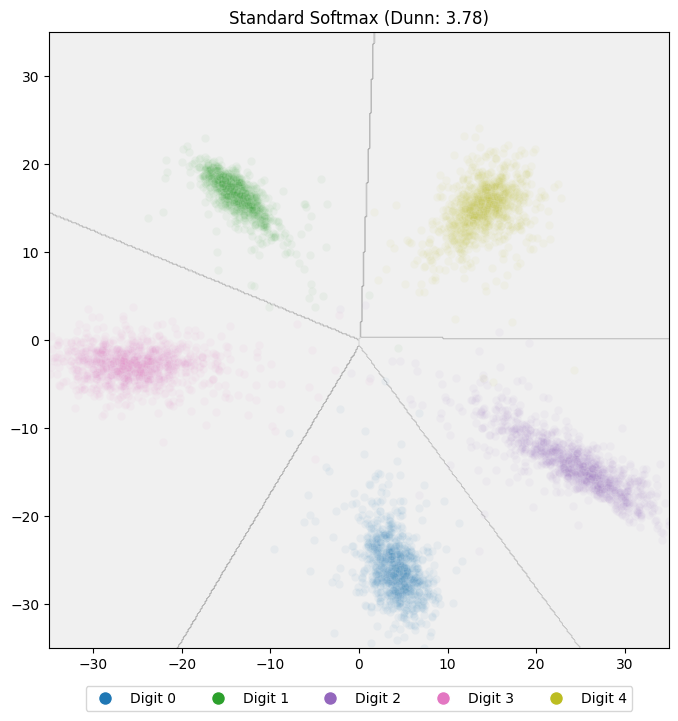

In [37]:
softmax_standard_dunn_index = dunn_index_for_model(
    softmax_standard_model, test_loader
)
plot_embeddings(
    softmax_standard_model,
    test_loader,
    x_range=(-35, 35),
    y_range=(-35, 35),
    title=f"Standard Softmax (Dunn: {softmax_standard_dunn_index:.2f})",
)

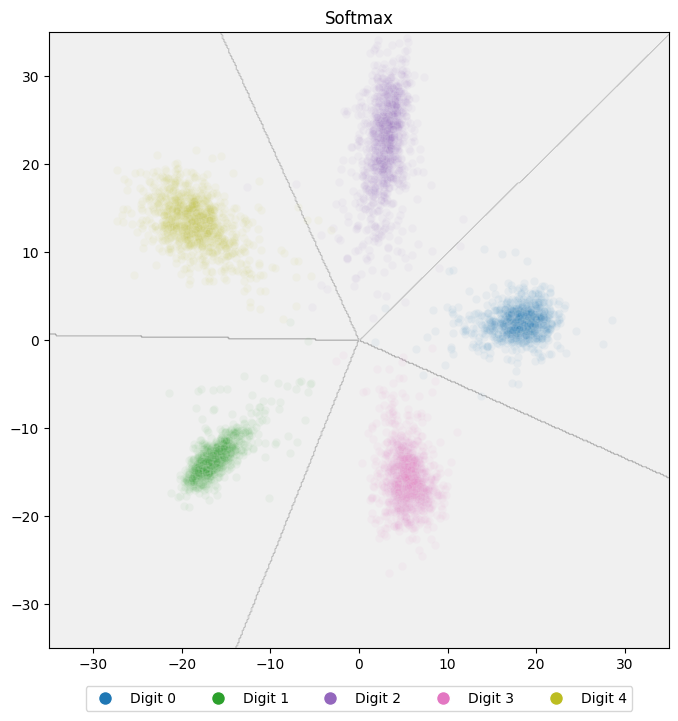

In [38]:
softmax_no_bias_dunn_index = dunn_index_for_model(
    softmax_no_classifier_bias_model, test_loader
)
plot_embeddings(
    softmax_no_classifier_bias_model,
    test_loader,
    x_range=(-35, 35),
    y_range=(-35, 35),
    title=f"Softmax",
)

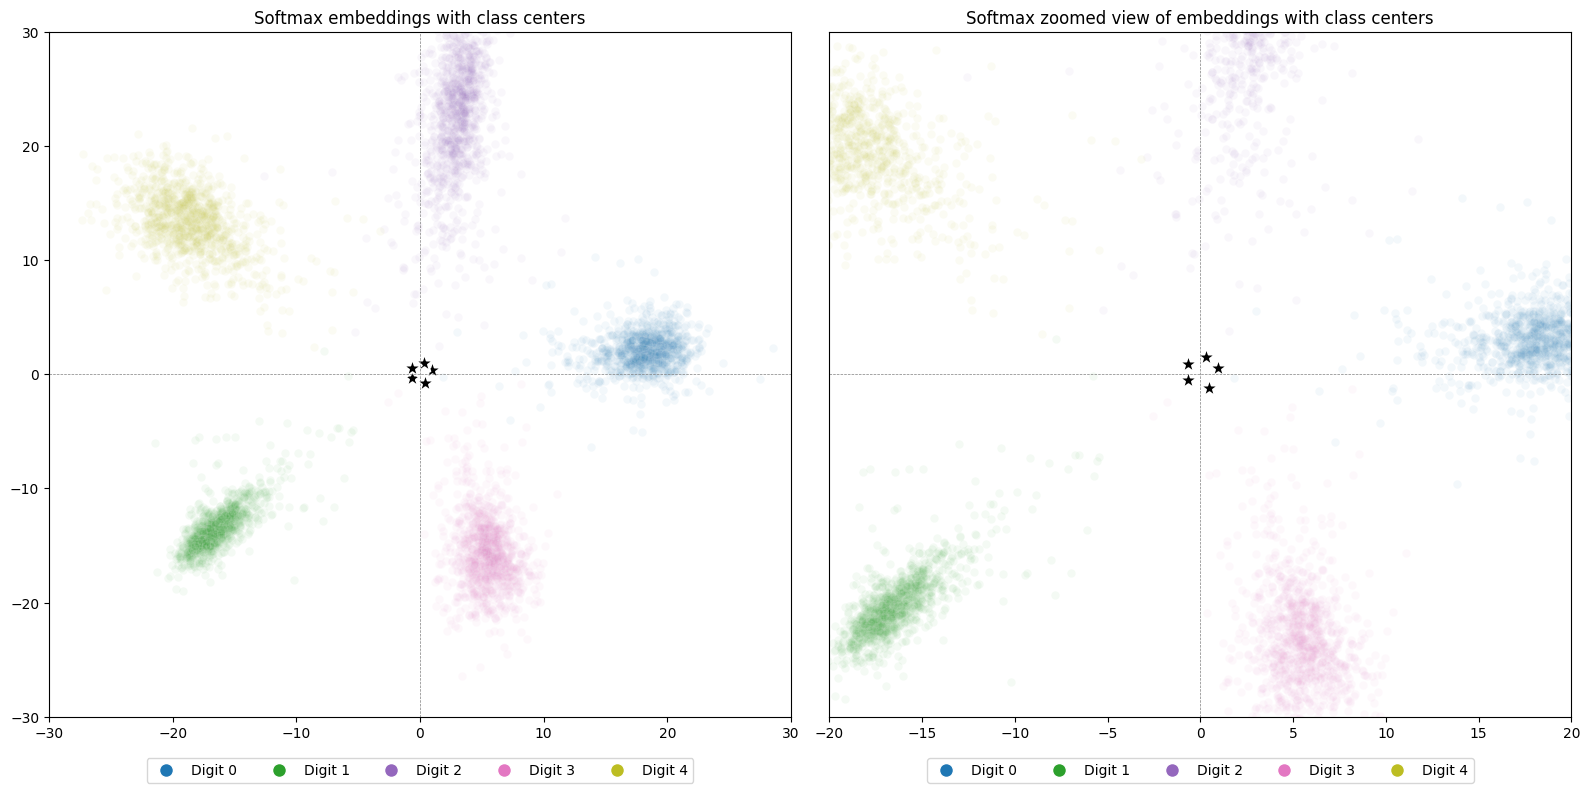

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=False)
ax2.tick_params(left=False, labelleft=False)

plot_embeddings(
    softmax_no_classifier_bias_model,
    test_loader,
    ax=ax1,
    x_range=(-30, 30),
    y_range=(-30, 30),
    title="Softmax embeddings with class centers",
    draw_class_centers=True,
    draw_decision_boundary=False,
    draw_axis_through_origin=True,
)
plot_embeddings(
    softmax_no_classifier_bias_model,
    test_loader,
    ax=ax2,
    x_range=(-20, 20),
    y_range=(-20, 20),
    title="Softmax zoomed view of embeddings with class centers",
    draw_class_centers=True,
    draw_decision_boundary=False,
    draw_axis_through_origin=True,
)
plt.tight_layout()

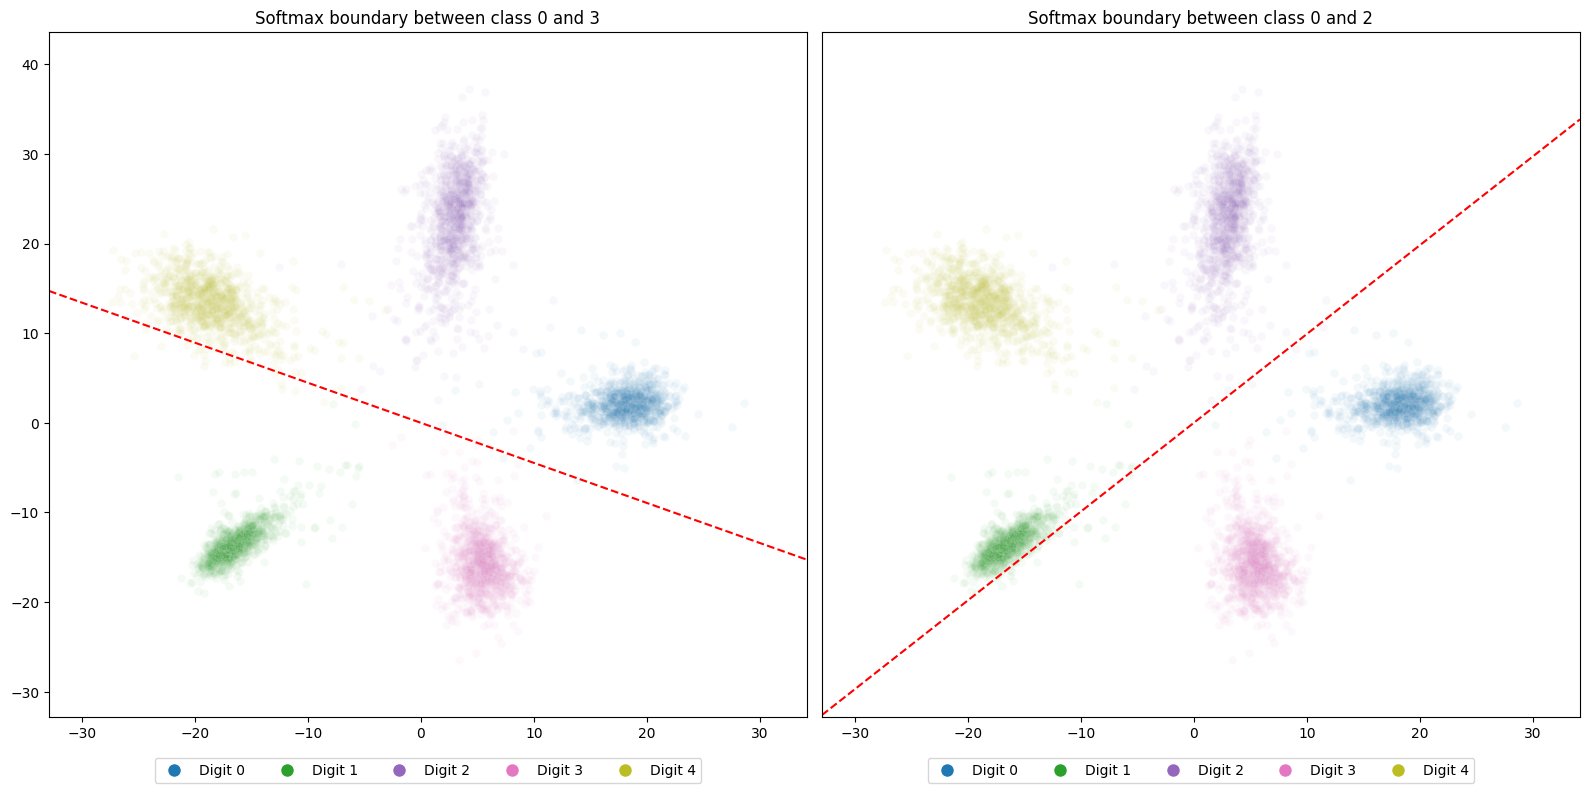

In [40]:
# Create side by side of different class boundaries
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
ax2.tick_params(left=False, labelleft=False)

plot_embeddings(
    softmax_no_classifier_bias_model,
    test_loader,
    ax=ax1,
    title=f"Softmax boundary between class 0 and 3",
    draw_class_boundary_lines=[(0,3)],
    draw_decision_boundary=False,
)
plot_embeddings(
    softmax_no_classifier_bias_model,
    test_loader,
    ax=ax2,
    title=f"Softmax boundary between class 0 and 2",
    draw_class_boundary_lines=[(0,2)],
    draw_decision_boundary=False,
)
plt.tight_layout()

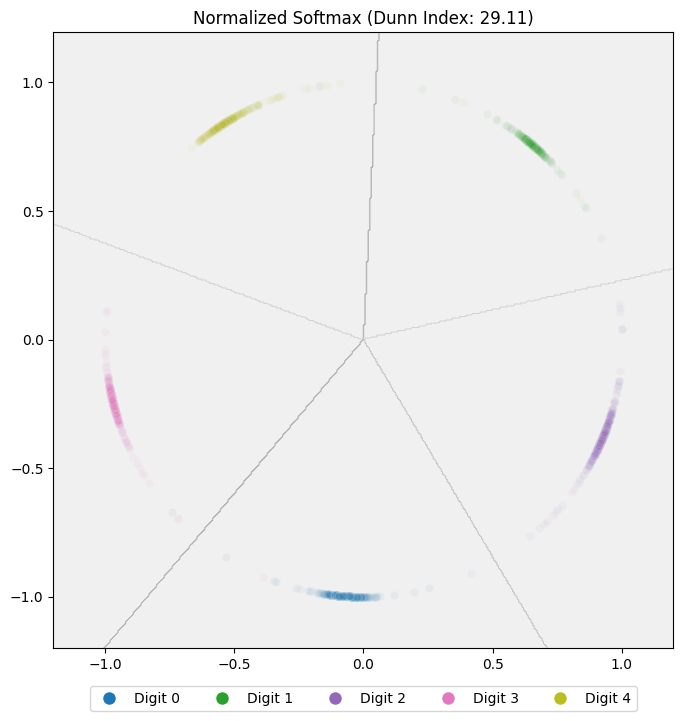

In [41]:
dunn_index_normalized = dunn_index_for_model(
    softmax_normalized_model, test_loader
)
plot_embeddings(softmax_normalized_model, test_loader, title=f"Normalized Softmax (Dunn Index: {dunn_index_normalized:.2f})")

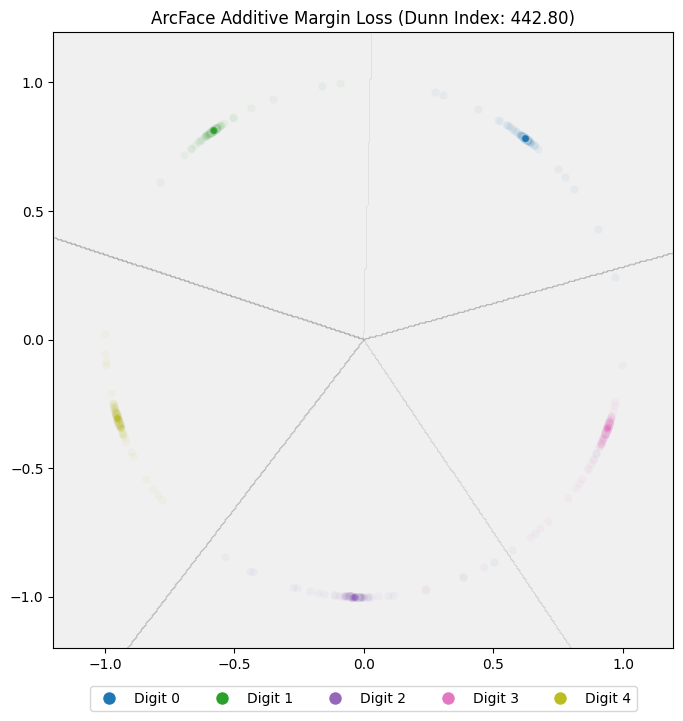

In [42]:
dunn_index_arcface = dunn_index_for_model(
    arcface_model, test_loader
)
plot_embeddings(
    arcface_model,
    test_loader,
    title=f"ArcFace Additive Margin Loss (Dunn Index: {dunn_index_arcface:.2f})"
)

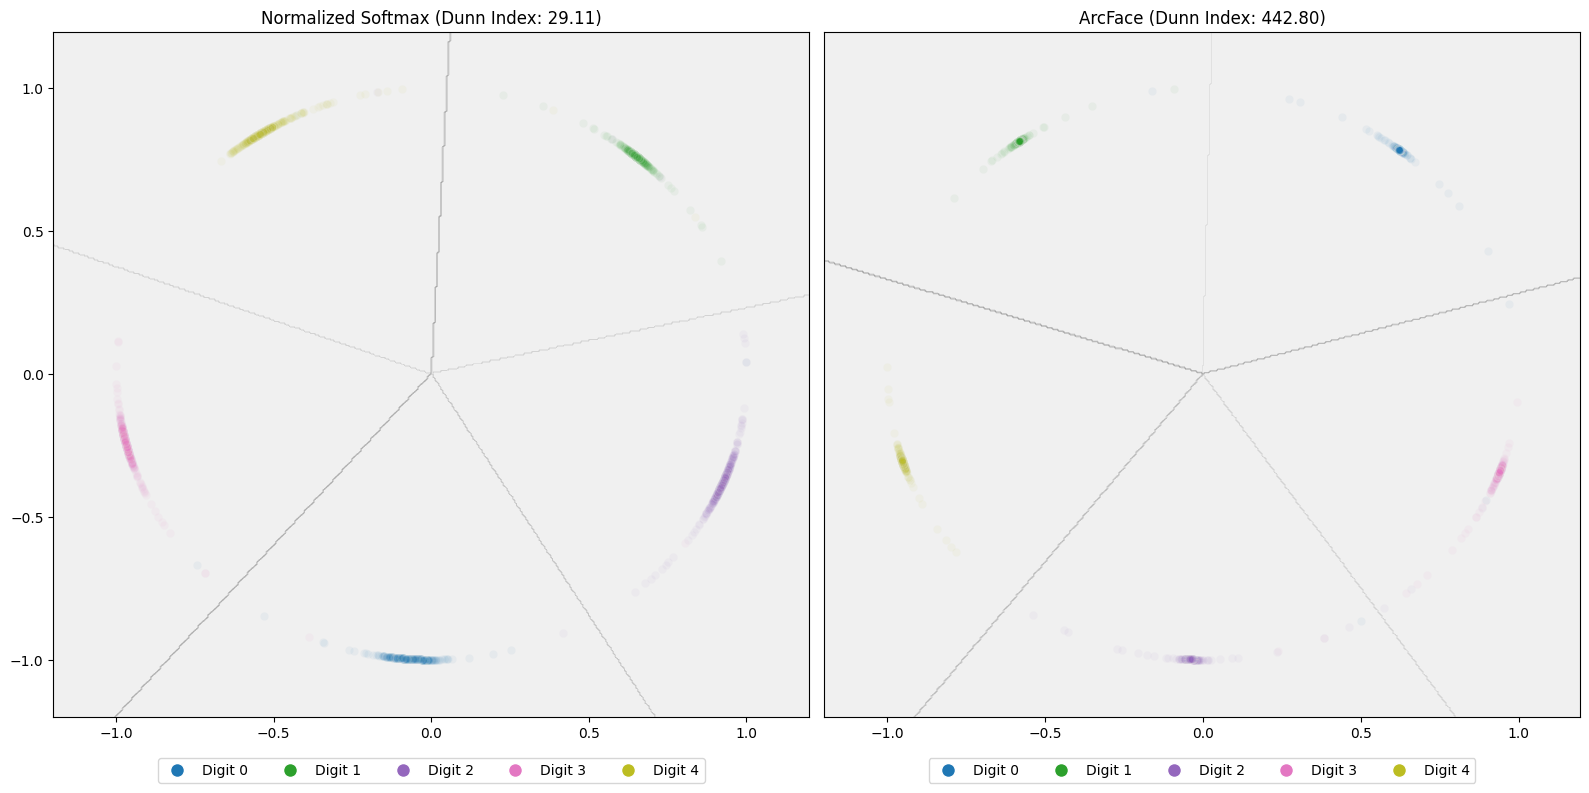

In [43]:
# Calculate Dunn Index for each model
dunn_index_normalized = dunn_index_for_model(
    softmax_normalized_model, test_loader
)
dunn_index_arcface = dunn_index_for_model(arcface_model, test_loader)

# Create a side-by-side plot of arcface and softmax normalized models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
ax2.tick_params(left=False, labelleft=False)

plot_embeddings(
    softmax_normalized_model,
    test_loader,
    ax=ax1,
    title=f"Normalized Softmax (Dunn Index: {dunn_index_normalized:.2f})"
)
plot_embeddings(
    arcface_model,
    test_loader,
    ax=ax2,
    title=f"ArcFace (Dunn Index: {dunn_index_arcface:.2f})"
)
plt.tight_layout()

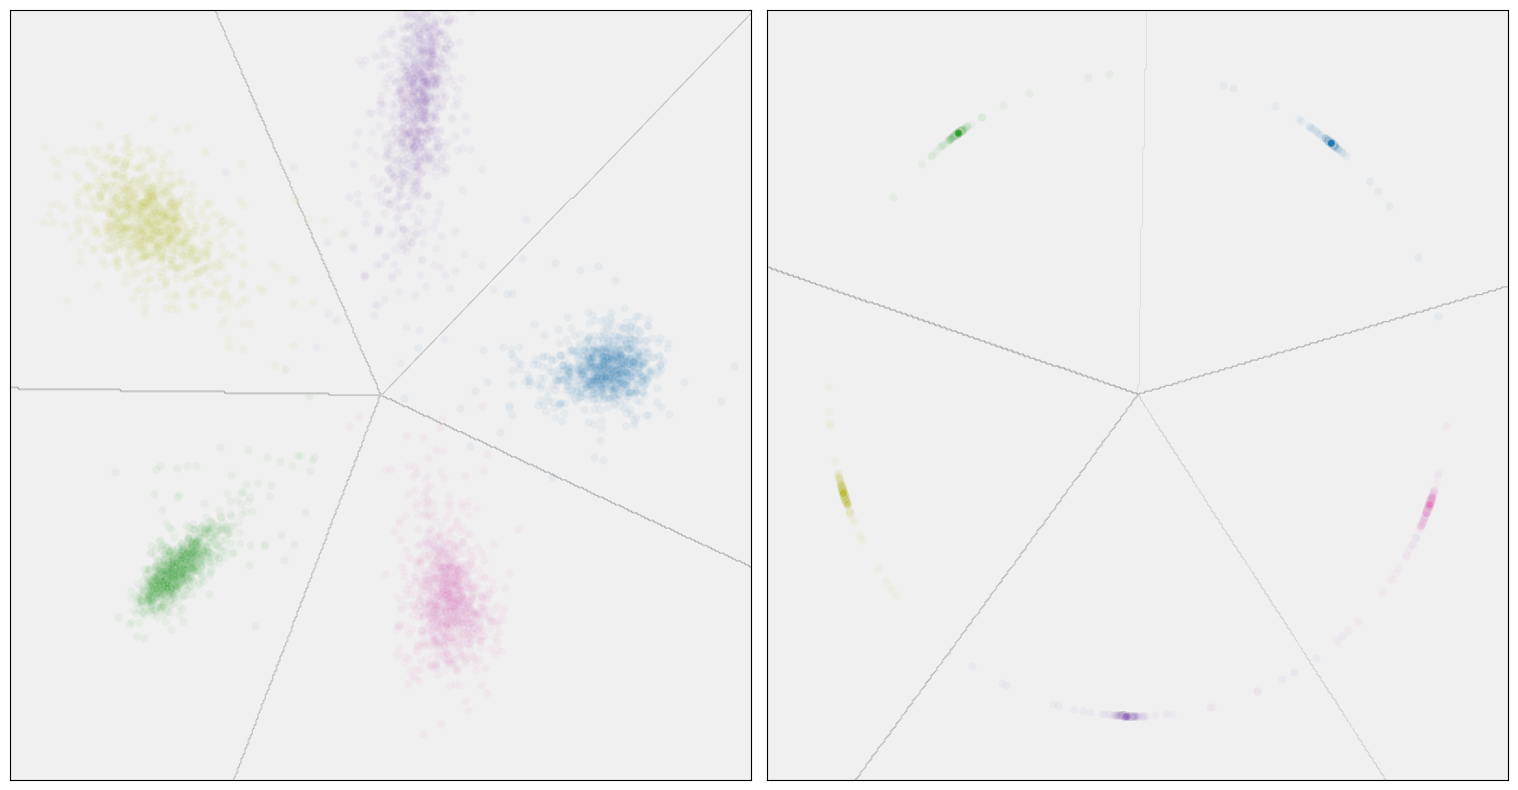

In [44]:
# Create a side-by-side plot for post header image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15.28, 8), sharey=False)
ax1.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax2.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

plot_embeddings(
    softmax_no_classifier_bias_model,
    test_loader,
    x_range=(-30, 30),
    y_range=(-30, 30),
    include_legend=False,
    ax=ax1,
)
plot_embeddings(
    arcface_model,
    test_loader,
    include_legend=False,
    ax=ax2,
)
plt.tight_layout()

In [45]:
@torch.no_grad()
def plot_points_with_class_centers(model, data_loader, points, point_labels, x_range=None, y_range=None, title=None, alpha=0.05, draw_axis_through_origin=False, ax=None):
    model.eval()

    embeddings, labels = get_all_embeddings_and_labels(
        model,
        data_loader
    )

    class_centers = get_class_centers(model)

    # Figure out bounds for x and y axes based on embeddings
    if x_range is None:
        x_min, x_max = embeddings[:, 0].min(), embeddings[:, 0].max()

        # Add some padding to the x bounds
        x_padding = 0.1 * (x_max - x_min)
        x_min -= x_padding
        x_max += x_padding
    else:
        x_min, x_max = x_range

    if y_range is None:
        y_min, y_max = embeddings[:, 1].min(), embeddings[:, 1].max()

        # Add some padding to the y bounds
        y_padding = 0.1 * (y_max - y_min)
        y_min -= y_padding
        y_max += y_padding
    else:
        y_min, y_max = y_range

    # Map each label to a distinct color
    cmap = plt.get_cmap("tab10")
    color_map = {i: cmap(i / num_classes) for i in range(num_classes)}

    if ax is None:
        plt.figure(figsize=(8, 8))
        ax = plt.gca()

    if draw_axis_through_origin:
        # Draw x and y axes through the origin
        ax.axhline(0, color='gray', linewidth=0.5, linestyle='--')
        ax.axvline(0, color='gray', linewidth=0.5, linestyle='--')

    def label_coordinate(x, y):
        if x < 0:
            x = x - 0.2
        if x >= 0:
            x = x + 0.2
        if y < 0:
            y = y - 0.2
        if y >= 0:
            y = y + 0.2
        return (x, y)

    for i in range(len(points)):
        # Plot the data points as vectors
        ax.quiver(
            0,
            0,
            points[i][0],
            points[i][1],
            angles='xy',
            scale_units='xy',
            scale=1,
            color=color_map[point_labels[i]],
            alpha=alpha,
            width=0.002,
            edgecolors="w",
        )
        label_x = points[i][0]
        label_y = points[i][1]
        label_x -= 1.2
        label_y += 0.5
        ax.text(
            *label_coordinate(points[i][0], points[i][1]),
            f"$x_{i}$",
            color="black",
            fontsize=10,
            ha='center',
            va='center',
        )
            

    # Plot the vectors for the class centers
    for i, center in enumerate(class_centers):
        ax.quiver(
            0, 0, center[0], center[1],
            angles='xy',
            scale_units='xy',
            scale=1,
            color= color_map[i],
            label=f"Class {i}",
            width=0.002,
        )
        label_text = f"$w_{i}$"

        ax.text(
            *label_coordinate(center[0], center[1]),
            label_text,
            color="black",
            fontsize=12,
            ha='center',
            va='center',
        )
        

    if title is not None:
        ax.set_title(title)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)


In [46]:
embedding = softmax_no_classifier_bias_model.embedding_net(
    train_dataset[0][0].unsqueeze(0)
).squeeze().detach().numpy()

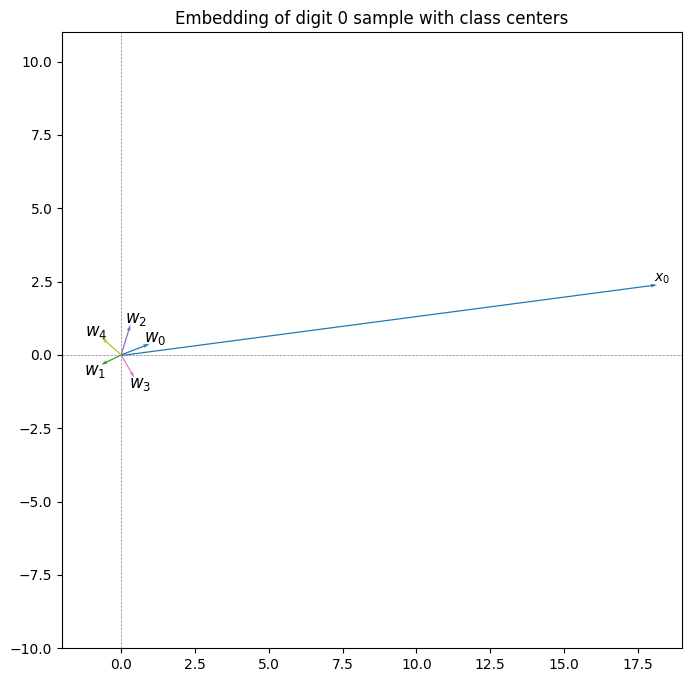

In [47]:
plot_points_with_class_centers(
    softmax_no_classifier_bias_model,
    test_loader,
    points=embedding[np.newaxis],
    point_labels=[train_dataset[0][1]],
    x_range=(-2, 19),
    y_range=(-10, 11),
    alpha=1.0,
    draw_axis_through_origin=True,
    title="Embedding of digit 0 sample with class centers"
)

## Scaling Logits

In [48]:
# When no scaling is applied, max probability is limited
logits = np.array([1.0, -1.0, -1.0, -1.0, -1.0])
raised_logits = math.e ** logits
raised_logits_sum = raised_logits.sum()
softmax_probs = raised_logits / raised_logits_sum
print("Softmax probabilities:", softmax_probs)
print("Sum of softmax probabilities:", softmax_probs.sum())

Softmax probabilities: [0.64878564 0.08780359 0.08780359 0.08780359 0.08780359]
Sum of softmax probabilities: 1.0


In [49]:
# When logits are scaled up before softmax, the max probability is much higher
logits = np.array([1.0, -1.0, -1.0, -1.0, -1.0])
logits *= 20
raised_logits = math.e ** logits
raised_logits_sum = raised_logits.sum()
softmax_probs = raised_logits / raised_logits_sum
print("Softmax probabilities:", softmax_probs)
print("Sum of softmax probabilities:", softmax_probs.sum())

Softmax probabilities: [1.00000000e+00 4.24835426e-18 4.24835426e-18 4.24835426e-18
 4.24835426e-18]
Sum of softmax probabilities: 1.0


## Displaying Digits

In [50]:
def display_images(digit_images, labels=None, columns=5):
    """
    Display a grayscale image of a digit.

    Args:
        digit_images (list of numpy.ndarray): List of 2D arrays
          representing the digit images
        labels (list of int): List of labels corresponding to the digit
          images
    """
    num_images = len(digit_images)
    rows = (num_images + columns - 1) // columns  # Calculate number of rows needed

    fig, axes = plt.subplots(rows, columns, figsize=(columns * 2, rows * 2))
    # Is axes list-like?
    if not isinstance(axes, np.ndarray):
        axes = np.array([[axes]])
    axes = axes.flatten()  # Flatten the 2D array of axes

    for i, digit_image in enumerate(digit_images):
        if digit_image.ndim == 3:
            digit_image = digit_image.squeeze()
        axes[i].imshow(digit_image, cmap="gray")
        axes[i].axis("off")
        # Put label _under_ the image if labels are provided
        if labels is not None:
            axes[i].text(
                0.5, -0.1,  # Position below the image
                f"{labels[i]}",
                fontsize=12,
                ha="center",
                va="top",
                transform=axes[i].transAxes
            )

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

In [51]:
def display_images_for_indices(dataset, indices, columns=5, display_labels=True):
    """
    Display images from a dataset for given indices.

    Args:
        dataset (torch.utils.data.Dataset): Dataset containing images
        indices (list of int): List of indices to display
    """
    digit_images = []
    for idx in indices:
        sample, _ = dataset[idx]
        digit_image = sample.squeeze().numpy()
        # Unnormalize the image
        digit_image = (digit_image * 0.3081) + 0.1307
        digit_images.append(digit_image)
    
    kwargs = {}
    if display_labels:
        kwargs['labels'] = indices

    display_images(digit_images, columns=columns, **kwargs)

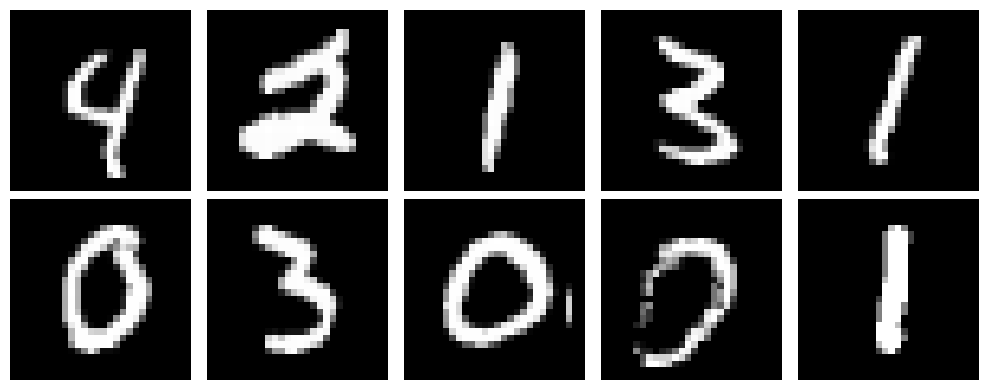

In [52]:
# Get 10 random indices from the test dataset
random_indices = np.random.choice(len(test_dataset), size=10, replace=False)
# Display images for those indices
display_images_for_indices(test_dataset, random_indices, columns=5, display_labels=False)

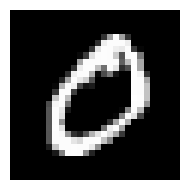

In [53]:
# Display example digit 0
display_images_for_indices(train_dataset, np.array([0]), columns=1, display_labels=False)

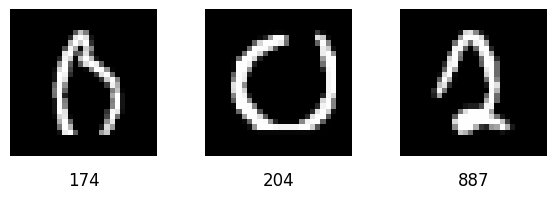

In [54]:
display_images_for_indices(
    test_dataset,
    [174, 204, 887],
    columns=3
)

In [55]:

embeddings, _ = get_all_embeddings_and_labels(
    softmax_no_classifier_bias_model.eval(),
    test_loader
)

In [56]:
distances_to_point([embeddings[174]], embeddings[204], metric="cosine")

array([0.15107924], dtype=float32)

In [57]:
distances_to_point([embeddings[174]], embeddings[887], metric="cosine")

array([0.13692415], dtype=float32)

In [58]:
embeddings_normalized, _ = get_all_embeddings_and_labels(
    softmax_normalized_model,
    test_loader
)

In [59]:
distances_to_point([embeddings_normalized[174]], embeddings_normalized[204], metric="cosine")

array([0.00026149], dtype=float32)

In [60]:
distances_to_point([embeddings_normalized[174]], embeddings_normalized[887], metric="cosine")


array([0.32035285], dtype=float32)

## Latex helpers

In [61]:
def matrix_to_latex(matrix, precision=2):
    """
    Convert a numpy matrix to a LaTeX formatted string.

    Args:
        matrix (numpy.ndarray): The matrix to convert
        precision (int): Number of decimal places to round to (default: 2)

    Returns:
        str: LaTeX formatted string representing the matrix
    """
    latex_str = "\\begin{bmatrix}\n"
    for row in matrix:
        row_str = " & ".join(f"{val:.{precision}f}" for val in row)
        latex_str += f"  {row_str} \\\\\n"
    latex_str += "\\end{bmatrix}"
    return latex_str

In [62]:
print(
    matrix_to_latex(
        softmax_no_classifier_bias_model.classifier.fc.weight.data.numpy().T
    )
)

\begin{bmatrix}
  0.96 & -0.67 & 0.31 & 0.45 & -0.66 \\
  0.37 & -0.33 & 1.03 & -0.77 & 0.59 \\
\end{bmatrix}


In [63]:
# Take sample and run it through the embedding network of softmax_no_classifier_bias_model
embedding = softmax_no_classifier_bias_model.embedding_net(
    train_dataset[0][0].unsqueeze(0)
).squeeze().detach().numpy()

In [64]:
print(matrix_to_latex([embedding]))

\begin{bmatrix}
  18.14 & 2.41 \\
\end{bmatrix}


In [65]:
embedding_arcface = arcface_model.embedding_net(
    train_dataset[0][0].unsqueeze(0)
).squeeze().detach().numpy()

In [66]:
print(matrix_to_latex([embedding_arcface]))

\begin{bmatrix}
  0.62 & 0.78 \\
\end{bmatrix}


In [67]:
print(
    matrix_to_latex(
        arcface_model.classifier.weight.data.numpy()
    )
)

\begin{bmatrix}
  0.37 & 0.46 \\
  -0.35 & 0.49 \\
  -0.05 & -1.19 \\
  0.34 & -0.12 \\
  -0.45 & -0.14 \\
\end{bmatrix}


In [68]:
print(
    matrix_to_latex(
        [
            embedding_arcface @ arcface_model.classifier.weight.data.numpy().T
        ]
    )
)

\begin{bmatrix}
  0.59 & 0.16 & -0.96 & 0.11 & -0.39 \\
\end{bmatrix}


In [69]:
class_centers = get_class_centers(softmax_no_classifier_bias_model)
print(matrix_to_latex([embedding @ class_centers.T]))

\begin{bmatrix}
  18.30 & -13.03 & 8.16 & 6.22 & -10.52 \\
\end{bmatrix}
